In [3]:
# import out dataset

%matplotlib inline

import pickle
import gzip

with gzip.open('data/mnist.pkl.gz', 'rb') as f:
               ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

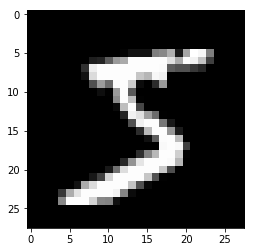

In [20]:
# plot a sample image

from matplotlib import pyplot
import numpy as np
pyplot.imshow(x_train[0].reshape([28,28]), cmap="gray")

In [22]:
# turn arrays into tensors

import torch

x_train, y_train, x_valid, y_valid = map(
    # converts numpy into tensor
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

/Users/moric/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [23]:
# what do they look like
y_train.min(), y_train.max()

(tensor(0), tensor(9))

In [57]:
import math

In [59]:
# initialize weights/biasesa
# 784 = size
# 10 = label size
weights = torch.randn(784,10) / math.sqrt(784)
# math.sqrt helps not explode 
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [60]:
# define activation function
# softmax as an example
# change init by 2
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # single dimension unsqueeze to match weights

# define our model
# take weights, take inputs, apply softmax
def model(xb):
    return log_softmax(xb @ weights + bias)


In [61]:
# make predictions with batches of 64 stochastic
bs = 64
xb = x_train[0:bs]
# mini batch of x
preds = model(xb)
# will give some
print(preds[0], preds.shape)

tensor([-2.3298, -2.5662, -2.6587, -1.8822, -2.8657, -2.5916, -2.7435, -2.5715,
        -1.6216, -2.0146], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [63]:
# define loss function (NLL)
def nll (logs, target):
    # take activations, what were the targets?
    return --logs[range(target.shape[0]), target].mean()

# a tensor that reduces value
loss_func = nll

In [64]:
# check starting loss
# do our batch of labels
yb = y_train[0:bs]
print(loss_func(preds, yb))

# tensor(0.1789, grad_fn<negBackwards>)

tensor(-2.3211, grad_fn=<NegBackward>)


In [65]:
# accuracy function
def accuracy(out, yb):
        preds = torch.argmax(out, dim=1)
        return (preds==yb).float().mean()
    
print(accuracy(preds, yb))

# tensor(0.9375)

tensor(0.0781)


In [68]:
# training loop

lr = 0.5
epochs = 2
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1): 
        # this gives us the number of batches
        start_i = i + bs # starting index of batch
        end_i = start_i + bs # ending index of batch
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            # .grad = gradients * learning rate
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            # manual your zero
            weights.grad.zero_()
            bias.grad.zero_()

In [69]:
# check our loss nd accuracy now
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

# tensor(0.55, grad_fn=<NegBackward>) tensor(1.)

tensor(nan, grad_fn=<NegBackward>) tensor(0.1094)


In [70]:
# nn = torch module
# nn.Functional

# module has its own loss function
# cross-entropy loss from softmax
import torch.nn.functional as F

loss_func = F.cross_entropy

# redefine model

def model(xb):
    return xb @ weights + bias

In [71]:
print(loss_func(model(xb), yb))

tensor(nan, grad_fn=<NllLossBackward>)


In [77]:
# nn.Module & nn.Parameter

from torch import nn

class Mnist_Logistic(nn.Module): 
# class_name(sub.class)
# how does the calling make its object
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    # auto make to send to optimizer
    
    # forward pass function of MNIST image to weights and bias
    def forward(self, xb):
        return xb @ self.weights * self.bias
    

In [78]:
# create out model class, by subclassing nn.Module
model = Mnist_Logistic()


In [84]:
# instantiate model with input data
# for loop

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1): 
            # this gives us the number of batches
            start_i = i + bs # starting index of batch
            end_i = start_i + bs # ending index of batch
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                # loop
                for p in model.parameters():
                    p -= p.grad * lr
                # gradient descent
                model.zero_grad()

In [85]:
fit()

In [86]:
# confirm our loss

# callable object
print(loss_func(model(xb), yb))


tensor(0.0063, grad_fn=<NllLossBackward>)


In [99]:
# nn.Linear class

from torch import nn

class Mnist_Logistic(nn.Module):
# how does the calling make its object
    def __init__(self):
        super().__init__()
        # self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        # self.bias = nn.Parameter(torch.zeros(10))
        self.lin = nn.Linear(784, 10)
    
    # forward pass function of MNIST image to weights and bias
    def forward(self, xb):
        return self.lin(xb)
    

In [94]:
# define our fit function



In [100]:
# call and check our model
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3559, grad_fn=<NllLossBackward>)


In [101]:
fit()
    

In [108]:
# use torch.optim to reset to zero for every call
from torch import optim

def get_model():
    # helper function
    model = Mnist_Logistic()
    # stochastic gradient descent vs adam, ada
    # optim.SGD(params=('lin') : lr : dictionary)
    return model, optim.SGD(model.parameters(), lr=lr) 
    # needs a learning rate with model parameters

In [109]:
# instantite model
model, opt = get_model()
print(loss_func(model(xb), yb))

# training looop
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1): 
        # this gives us the number of batches
        
        # ---- data load clunky
        start_i = i + bs # starting index of batch
        end_i = start_i + bs # ending index of batch
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        # ---- data load end
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
    

tensor(2.3267, grad_fn=<NllLossBackward>)


In [ ]:
# make data loading cleaner aka with less code



In [ ]:
# dictionary, and pass